In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import dataset
from model import ResNet18YOLOv1
from loss import YOLOv1Loss
from tqdm import tqdm
from evaluate import get_bboxes, mean_average_precision

In [5]:
pascal_voc_train = torchvision.datasets.VOCDetection(
    root="data",
    year="2007",
    image_set="train",
    download=False
)

pascal_voc_val = torchvision.datasets.VOCDetection(
    root="data",
    year="2007",
    image_set="val",
    download=False
)

In [6]:
voc_train = dataset.PascalVOC(pascal_voc=pascal_voc_train)
voc_val = dataset.PascalVOC(pascal_voc=pascal_voc_val)

In [7]:
# load model
yolo = ResNet18YOLOv1()
yolo.load_state_dict(torch.load("best_model.pth", map_location="cpu"))
yolo.eval()

ResNet18YOLOv1(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): LeakyReLU(negative_slope=0.1, inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-

tensor([[ 0.5705,  0.1985,  0.4396,  0.7490,  0.8439,  0.8519, 11.0000]],
       grad_fn=<CatBackward0>)
cateogry: dog


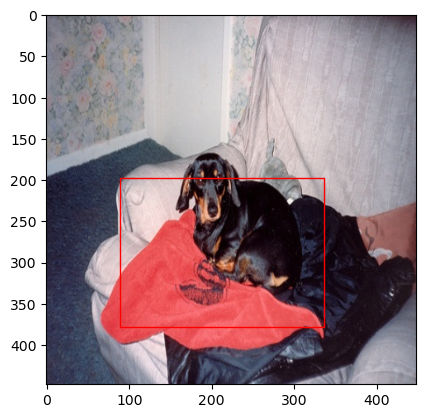

In [40]:
i = 20

X, Y = voc_val[i]
X = X.unsqueeze(0)
pred = yolo(X)[0]
bboxes = get_bboxes(pred, confidence_threshold=0.2)
print(bboxes)

fig, ax = plt.subplots()

for bbox in bboxes:
    confidence = bbox[0]
    x1y1x2y2 = bbox[1:5]
    probability = bbox[5]
    class_idx = bbox[6]
    
    category = dataset.PascalVOC.categories_list[int(class_idx)]
    print(f"cateogry: {category}")
    
    x1y1x2y2 = x1y1x2y2.detach().numpy() * 448
    x1 = x1y1x2y2[0]
    y1 = x1y1x2y2[1]
    x2 = x1y1x2y2[2]
    y2 = x1y1x2y2[3]
    
    width = x2 - x1
    height = y2 - y1
    
    rect = patches.Rectangle((x1, y1), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Resize((448, 448))])
img = transform(pascal_voc_val[i][0]).permute((1, 2, 0))
ax.imshow(img)